In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.decomposition import PCA
import torch.utils.data
import pickle
from tqdm import tqdm
import time
import gc
import collections

In [2]:
from torchvision.datasets import ImageFolder

In [3]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.nn import Sequential
import os
from torchvision.datasets import DatasetFolder
from sklearn.metrics import f1_score
import sys

In [4]:
base_path = '.'
train_path = base_path + '/train_data'
train_medium_path = train_path + '/medium'

val_path = base_path + '/validation_classification'
val_medium_path = val_path + '/medium'

test_path = base_path + '/test_classification'
test_medium_path = test_path + '/medium'

In [5]:
class MyImageFolder(ImageFolder):
    def _find_classes(self, dir):
        """
        Finds the class folders in a dataset.

        Args:
            dir (string): Root directory path.

        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.

        Ensures:
            No class is a subdirectory of another.
        """
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

In [9]:
transform_image = transforms.Compose([
        transforms.Resize(64),
        transforms.RandomCrop(64),
        transforms.ToTensor()
])

In [10]:
val_imagefolder = MyImageFolder(val_medium_path, transform = transform_image)
image_val_dataloader = DataLoader(val_imagefolder,
                                    batch_size = 32,
                                    drop_last = False,
                                    shuffle = True)

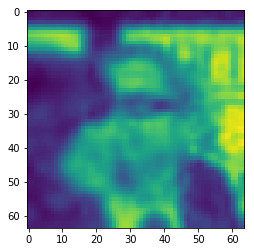

In [11]:
plt.imshow(val_imagefolder[3][0][0])

In [12]:
val_imagefolder[3][1]

1

In [13]:
from PIL import Image

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [14]:
class TestImageFolder(DatasetFolder):
    
    def __init__(self, root, extensions=None, transform=None):
        super(DatasetFolder, self).__init__(root, transform=transform)
        
        self.root = root
        self.loader = default_loader
        self.extensions = extensions
        self.samples = list(os.walk(root))[0][2]
    

    def __getitem__(self, index):
        
        file_name = self.samples[index]
        sample = self.loader(os.path.join(self.root, file_name))
        if self.transform is not None:
            sample = self.transform(sample)

        return sample


    def __len__(self):
        return len(self.samples)


In [17]:
def val_accuracy(model):
    
    with torch.no_grad():
        model.eval().cuda()
        y_pred = []
        y_true = []
        for index, (val_features, val_labels) in enumerate(image_val_dataloader):
            val_features = val_features.cuda()

            outputs = model(val_features).view(val_labels.shape[0], -1)
            predictions = torch.max(outputs.data, 1)[1]
            y_pred += list(predictions.data.cpu().numpy())
            y_true += list(val_labels.numpy())
        
    f1 = f1_score(y_true = y_true, y_pred = y_pred, average='weighted')
    
    return f1

In [18]:
def val_accuracy(model):
    
    with torch.no_grad():
        model.eval().cuda()
        y_pred = []
        y_true = []
        for index, (val_features, val_labels) in enumerate(image_val_dataloader):
            val_features = val_features.cuda()

            outputs = model(val_features).view(val_labels.shape[0], -1)
            predictions = torch.max(outputs.data, 1)[1]
            y_pred += list(predictions.data.cpu().numpy())
            y_true += list(val_labels.numpy())
        
    return sum(np.array(y_true) == np.array(y_pred))/len(y_true)

In [14]:
class MyCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.convolutional_layers = Sequential(
            #first part-29
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 4, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout2d(0.2),

            #second part-14
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 2, stride = 2, padding = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout2d(0.2)
        )

        self.output_layers = Sequential(
            nn.Linear(2048, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(2048, 2300)
        )


    def forward(self, x):

        conv_output = self.convolutional_layers(x)
        
        output = self.output_layers(conv_output.view(conv_output.shape[0], -1))
        
        return output

In [19]:
from torch.nn import ReLU, Conv2d, MaxPool2d, BatchNorm1d, BatchNorm2d

In [57]:
class MyVGG(nn.Module):
    
    def __init__(self):
        super().__init__()
        inplace = True
        
        self.convolutional_layers = Sequential(
            Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        self.output_layers = Sequential(
            nn.Linear(512, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(0.1),
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Dropout(0.1),
            nn.Linear(2048, 2300)
        )


    def forward(self, x):

        conv_output = self.convolutional_layers(x)
        
        output = self.output_layers(conv_output.view(conv_output.shape[0], -1))
        
        return output

In [31]:
class MyVGG(nn.Module):
    
    def __init__(self):
        super().__init__()
        inplace = True
        
        self.convolutional_layers = Sequential(
            Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(inplace),
            MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        self.output_layers = Sequential(
            nn.Linear(32768, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(0.1),
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Dropout(0.1),
            nn.Linear(2048, 2300)
        )


    def forward(self, x):

        conv_output = self.convolutional_layers(x)
        
        output = self.output_layers(conv_output.view(conv_output.shape[0], -1))
        
        return output

In [12]:
'''class MyCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.convolutional_layers = Sequential(
            nn.ReLU()
        )

        self.output_layers = Sequential(
            nn.Linear(3072, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(2048, 2300)
        )


    def forward(self, x):

        conv_output = self.convolutional_layers(x)
        output = self.output_layers(conv_output.view(conv_output.shape[0], -1))
        
        return output'''

In [ ]:
'''class MyVGG(nn.Module)'''

In [21]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [136]:
model = torch.hub.load('pytorch/vision:v0.5.0', 'vgg11', pretrained=True)

Using cache found in C:\Users\1/.cache\torch\hub\pytorch_vision_v0.5.0


In [33]:
model = MyVGG()
model.apply(init_weights)

C:\Users\1\Anaconda3\envs\python3.5\lib\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


MyVGG(
  (convolutional_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output_layers): Sequential(
    (0): Linear(in_features=32768, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=4096, out_features=2048, bias=True)
    (5): BatchNorm1d(2048, eps=1e-05, momentum=0.1,

In [26]:
imagefolder = MyImageFolder(train_medium_path, transform = transform_image)

In [27]:
counts = [imagefolder.targets.count(target) for target in range(2300)]
target_counts = np.array([counts[target] for target in imagefolder.targets])

In [28]:
target_weights = 1/target_counts
weighted_sampler = WeightedRandomSampler(weights = target_weights,
                                         replacement = True,
                                         num_samples = len(target_weights))

In [36]:
image_train_dataloader = DataLoader(imagefolder,
                                    batch_size = 64,
                                    drop_last = False,
                                    shuffle = False,
                                    sampler = weighted_sampler)

In [29]:
torch.cuda.empty_cache()

In [34]:
val_accuracy(model)

0.0004347826086956522

In [37]:
#15 epoches to 47%
for i in range(100):
    model.train().cuda()
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, weight_decay = 0, momentum = 0.9)
    
    avg_loss = 0
    '''    
    train_pred = []
    train_true = []
    '''
    for index, (features, labels) in enumerate(image_train_dataloader):
        optimizer.zero_grad()
        '''
        train_true += list(labels.numpy())
        '''
        features = features.cuda()
        labels = labels.cuda()
        
        output = model(features).view(labels.shape[0], -1)
        loss = criterion(output, labels.long())
        loss.backward()
        avg_loss += loss.item()
        '''        
        predictions = torch.max(output.data, 1)[1]
        train_pred += list(predictions.data.cpu().numpy())
        '''
        optimizer.step() 
        
        if index%1000 == 0 and index != 0:
            print("average loss:", avg_loss/1000)
            avg_loss = 0
            '''            
            print("f1_score:",f1_score( y_true=train_true, y_pred=train_pred, average='weighted'))
            train_true = []
            train_pred = [] 
            '''
    print("Epoch {0} Done.".format(i+1))
    print("Validation Accuracy", val_accuracy(model))

average loss: 7.701126388072968
average loss: 7.347619277477264
average loss: 7.086101522922516
average loss: 6.856671692371369
average loss: 6.6622455458641054
average loss: 6.483898948192596
average loss: 6.3314166231155395
average loss: 6.179625605583191
average loss: 6.033585300445557
average loss: 5.898634771347046
average loss: 5.752074809074402
average loss: 5.627170861244202
Epoch 1 Done.
Validation Accuracy 0.11043478260869566
average loss: 5.386026895523071
average loss: 5.2705832796096805
average loss: 5.138296898841858
average loss: 5.014059167385101
average loss: 4.911017042160034
average loss: 4.797651696205139
average loss: 4.688587040901184
average loss: 4.576223440885544
average loss: 4.497058034181594
average loss: 4.391749188423157
average loss: 4.2895171909332275
average loss: 4.213729162216186
Epoch 2 Done.
Validation Accuracy 0.25369565217391304
average loss: 4.051757622957229
average loss: 3.9613748376369475
average loss: 3.890374097824097
average loss: 3.8171429

Exception ignored in: <bound method Image.__del__ of <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=32x32 at 0x2C23064C278>>
Traceback (most recent call last):
  File "C:\Users\1\Anaconda3\envs\python3.5\lib\site-packages\PIL\Image.py", line 629, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: 

In [38]:
pickle.dump(model, open('vgg_trial.pkl','wb'))

In [69]:
def make_classification_submission(model, idx_to_class, test_path = test_medium_path):
    '''
    using customized dataset
    '''
    test_dataset = TestImageFolder(test_path, transform = transform_image)
    test_dataloader = DataLoader(test_dataset, 
                             batch_size = 32,
                             drop_last = False,
                             shuffle = False)
    
    submission_indices = test_dataloader.dataset.samples
    submission_prediction = []
    for index, (img) in enumerate(test_dataloader):
        model.eval().cuda()
        img = img.cuda()

        outputs = model(img).view(img.shape[0], -1)
        predictions = torch.max(outputs.data, 1)[1]
        submission_prediction += list(predictions.data.cpu().numpy())
    
    submission_prediction = [idx_to_class[i] for i in submission_prediction]
    submission_df = pd.DataFrame({'Category': submission_prediction}, index = submission_indices)
    submission_df.to_csv('submission.csv', index_label = 'Id')
    print("Submission File Saved.")

In [70]:
val_accuracy(model)

0.4980434782608696

In [72]:
idx_to_class = {j:i for i, j in val_imagefolder.class_to_idx.items()}
make_classification_submission(model, idx_to_class)

Submission File Saved.
